In [1]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [2]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
from randaugment import RandAugmentMC

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [4]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.9 
LAMBDA_U = 3
MU = 4 # Coefficient for scaling the unlabeled loss
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [6]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)

        return x

In [7]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.49135667 0.48212072 0.4465159 ], std: [0.24632095 0.24274482 0.26062676]
Files already downloaded and verified


In [8]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## IV. Semi-Supervised Learning: Fixmatch - Data Alignment

### IV.1 Fixmatch on 10% train data - Data Alignment

In [9]:
# load indices
indices = torch.load('CIFAR10_InceptionV3_Submodular_exp0_epoch200_2023-06-21 14:25:02.022756_0.1_74.880000.pt')

In [10]:
def create_labeled_dataset_active_learning(dataset, selected_indices):
    dataset = torch.utils.data.Subset(dataset, selected_indices)
    return dataset

In [11]:
trainset_sup = create_labeled_dataset_active_learning(trainset, indices)

In [12]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.10
CIFAR10_class_distribution = 0.10

# 10% labeled data and 100% unlabeled (see note 2 in paper)
# trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [13]:
# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    RandAugmentMC(n=2, m=10),
    transforms.Normalize(mean, std)
])
    

In [14]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

In [15]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [16]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": torch.mean(max_qb).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)


Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 23.01%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 33.37%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 34.32%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 40.91%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 43.5%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 40.84%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.12%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.64%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 42.41%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.19%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.66%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.41%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.71%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.5%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.03%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.71%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.75%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.13%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.91%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.4%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.28%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.53%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.69%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.99%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.88%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.2%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.93%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.44%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.05%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.11%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.3%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.83%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.43%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.08%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.34%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.96%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.13%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.34%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.94%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.58%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.18%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.93%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.1%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.57%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.64%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.72%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.12%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.97%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.53%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.1%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.18%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.31%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.23%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.98%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.17%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.51%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.33%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.64%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.87%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.42%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.45%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.94%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.78%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.93%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.79%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.71%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.05%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.66%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.9%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.68%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.53%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.07%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.36%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.42%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.96%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.9%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.03%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.8%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.04%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.73%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.54%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.93%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.41%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.85%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.32%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.16%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.02%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.22%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.83%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.03%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.78%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.76%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.95%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.15%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.76%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.04%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.32%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.3%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.65%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.9%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.19%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.18%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.83%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.84%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.35%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.69%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.84%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.38%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.64%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.83%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.27%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.76%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.04%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.98%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.81%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.37%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.08%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.53%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.0%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.96%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.05%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.79%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.38%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.49%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.25%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.45%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.4%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.66%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.71%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.7%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.9%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.76%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.35%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.94%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.26%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.7%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.13%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.81%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.09%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.3%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.84%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.24%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.21%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.03%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.47%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.08%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.59%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.56%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.15%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.88%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.06%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.06%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.71%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.27%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.27%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.62%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.36%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.75%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.66%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.98%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.67%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.31%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.2%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.63%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.62%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.04%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.94%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.37%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.84%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.19%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.5%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.14%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.56%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.08%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.03%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.14%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.52%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.79%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.02%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.13%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.1%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.31%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.5%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.77%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.25%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.5%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.15%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.48%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.96%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.16%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.62%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.1%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.08%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.93%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.96%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.53%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.45%


Epoch   200:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.44%


Epoch   201:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.09%


Epoch   202:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.71%


Epoch   203:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.03%


Epoch   204:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.73%


Epoch   205:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.57%


Epoch   206:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.91%


Epoch   207:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.49%


Epoch   208:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.39%


Epoch   209:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.76%


Epoch   210:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.79%


Epoch   211:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.86%


Epoch   212:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.61%


Epoch   213:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.2%


Epoch   214:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.23%


Epoch   215:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.82%


Epoch   216:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.66%


Epoch   217:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.98%


Epoch   218:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.7%


Epoch   219:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.13%


Epoch   220:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.78%


Epoch   221:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.68%


Epoch   222:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.63%


Epoch   223:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.08%


Epoch   224:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.23%


Epoch   225:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.35%


Epoch   226:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.37%


Epoch   227:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.7%


Epoch   228:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.98%


Epoch   229:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.71%


Epoch   230:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.49%


Epoch   231:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.5%


Epoch   232:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.23%


Epoch   233:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.61%


Epoch   234:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.96%


Epoch   235:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.22%


Epoch   236:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.6%


Epoch   237:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.45%


Epoch   238:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.73%


Epoch   239:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.94%


Epoch   240:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.05%


Epoch   241:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.26%


Epoch   242:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.9%


Epoch   243:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.76%


Epoch   244:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.51%


Epoch   245:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.11%


Epoch   246:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.04%


Epoch   247:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.1%


Epoch   248:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.11%


Epoch   249:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.36%


Epoch   250:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.29%


Epoch   251:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.62%


Epoch   252:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.82%


Epoch   253:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.94%


Epoch   254:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.89%


Epoch   255:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.73%


Epoch   256:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch   257:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.94%


Epoch   258:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.06%


Epoch   259:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.82%


Epoch   260:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.16%


Epoch   261:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.19%


Epoch   262:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch   263:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.08%


Epoch   264:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.48%


Epoch   265:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.65%


Epoch   266:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.49%


Epoch   267:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.45%


Epoch   268:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.08%


Epoch   269:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.13%


Epoch   270:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.22%


Epoch   271:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.51%


Epoch   272:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.61%


Epoch   273:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.5%


Epoch   274:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.45%


Epoch   275:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.53%


Epoch   276:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.56%


Epoch   277:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.5%


Epoch   278:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.41%


Epoch   279:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.46%


Epoch   280:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.49%


Epoch   281:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.41%


Epoch   282:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.58%


Epoch   283:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.37%


Epoch   284:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.61%


Epoch   285:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.53%


Epoch   286:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.35%


Epoch   287:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.62%


Epoch   288:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.55%


Epoch   289:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.71%


Epoch   290:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.68%


Epoch   291:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.6%


Epoch   292:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.53%


Epoch   293:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.61%


Epoch   294:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.62%


Epoch   295:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


Epoch   296:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.66%


Epoch   297:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


Epoch   298:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


Epoch   299:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


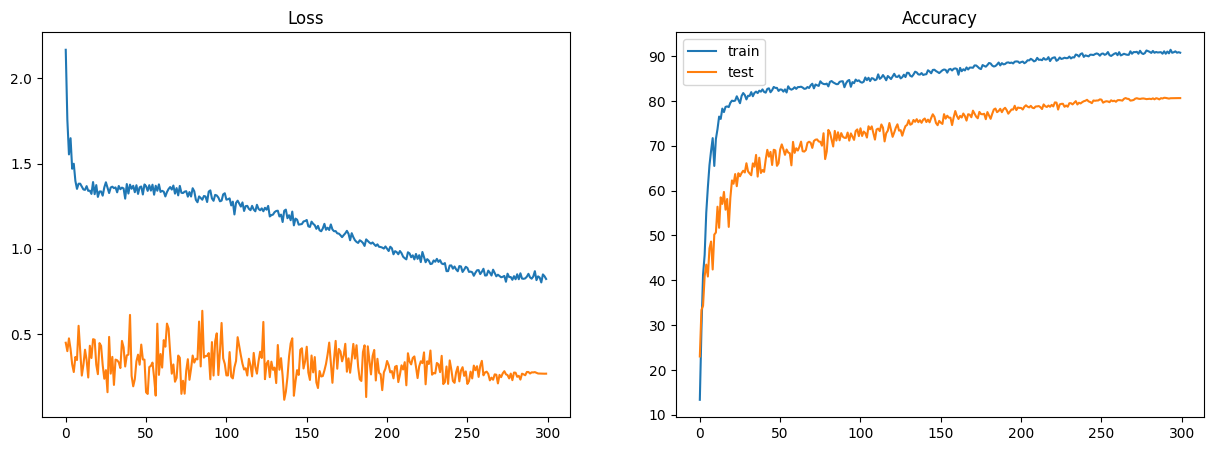

In [17]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_GC_10_losses_accuracies.png")

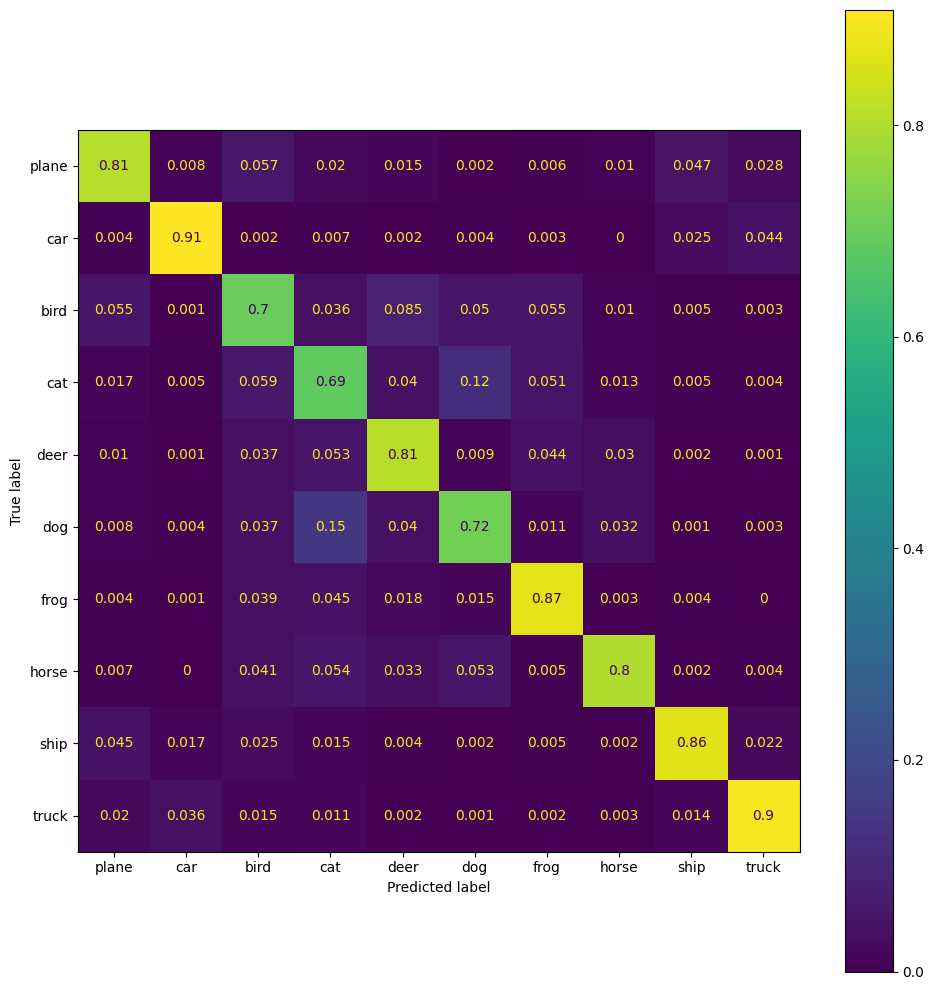

In [18]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_GC_10_confusion_matrix.png")

Test Accuracy: 80.64%


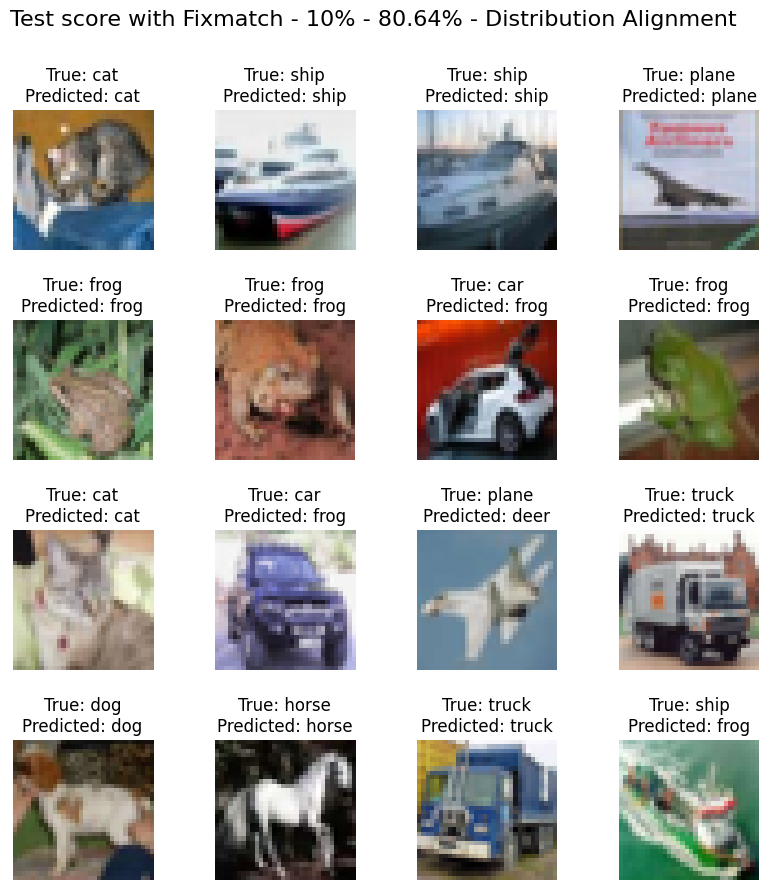

In [19]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch_GC.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Distribution Alignment")
fig1.savefig(f"./figures/test_score_10_fixmatch_GC.png")

### IV.2 Fixmatch on 5% train data - Data Alignment

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 200
SUBSET_PROP = 0.05
CIFAR10_class_distribution = 0.10

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm, unlabeled_inputs_norm = normalize(labeled_inputs, mean, std), normalize(unlabeled_inputs, mean, std)

        # labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        # moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = CIFAR10_class_distribution / moving_avg_pred_unlabeled
        # model.train()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_DA_5_losses_accuracies.png")

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_DA_5_confusion_matrix.png")

In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Data Alignment")
fig1.savefig(f"./figures/test_score_5_fixmatch_DA.png")

### IV.3 Fixmatch on 1% train data - Data Alignment

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.01
CIFAR10_class_distribution = 0.10 

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm, unlabeled_inputs_norm = normalize(labeled_inputs, mean, std), normalize(unlabeled_inputs, mean, std)

        # labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        # moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = CIFAR10_class_distribution / moving_avg_pred_unlabeled
        # model.train()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_DA_1_losses_accuracies.png")

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_DA_1_confusion_matrix.png")

In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Data Alignment")
fig1.savefig(f"./figures/test_score_1_fixmatch_DA.png")